#### The goal of this project file is to predict flow using ppt data

Version 2: only predict 2018 daily data at subwatershed 8

In [1]:
import pandas as pd
import math
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pprint import pprint

%matplotlib inline

In [2]:
# importing flow dataset
df_flow = pd.read_excel('Daily ISCO flow and precipitation.xlsx', sheet_name = 'Sheet1')


df_flow = df_flow.drop(columns=['Daily precip (in)','Daily precip (mm)','S12-ISCO flow (cms)','T12-ISCO flow (cms)'])

df_flow = df_flow.rename(columns={'T8-ISCO flow (cms)':'Flow8', 'S11-ISCO flow (cms)':'Flow11', 'S12+T12':'Flow12'})

#df_flow = pd.DataFrame(df_flow, columns=['Sample date', 'Sample type', 'Site', 'Flow'])
df_flow.describe()

,Flow8,Flow11,Flow12
count,925.000000,899.000000,817.000000
mean,0.075407,0.023929,0.031363
std,0.074824,0.042299,0.035388
min,0.000000,0.000000,0.000000
25%,0.022000,0.002000,0.011000
50%,0.065000,0.012000,0.020000
75%,0.097000,0.027000,0.037000
max,0.591000,0.452000,0.366000


In [3]:
# importing weather dataset
df_weather = pd.read_excel('Weather data.xlsx', sheet_name = 'Weather')
df_weather = df_weather.rename(columns={'ppt (mm)':'ppt','tmin (degrees C)':'tmin','tmean (degrees C)':'tmean',
                                        'tmax (degrees C)':'tmax', 'tdmean (degrees C)':'tdew', 'vpdmin (hPa)': 'vpdmin', 
                                        'vpdmax (hPa)': 'vpdmax'})

df_weather['Year'] = pd.DatetimeIndex(df_weather['Date']).year
df_weather['Month'] = pd.DatetimeIndex(df_weather['Date']).month
df_weather['Day'] = pd.DatetimeIndex(df_weather['Date']).day
df_weather['Day of year'] = df_weather['Date'].dt.dayofyear

# calculate antecedent ppt and temperature
# 2-day antecedent cumulative ppt (mm)
df_weather['2-day ppt'] = round(df_weather.iloc[:,1].rolling(window=2).sum(), 1)

# 3-day antecedent cumulative ppt (mm)
df_weather['3-day ppt'] = round(df_weather.iloc[:,1].rolling(window=3).sum(), 1)

# 5-day antecedent cumulative ppt (mm)
df_weather['5-day ppt'] = round(df_weather.iloc[:,1].rolling(window=5).sum(), 1)

# 7-day antecedent cumulative ppt (mm)
df_weather['7-day ppt'] = round(df_weather.iloc[:,1].rolling(window=7).sum(), 1)

# 15-day antecedent cumulative ppt (mm)
df_weather['15-day ppt'] = round(df_weather.iloc[:,1].rolling(window=15).sum(), 1)

# 30-day antecedent cumulative ppt (mm)
df_weather['30-day ppt'] = round(df_weather.iloc[:,1].rolling(window=30).sum(), 1)

# 90-day antecedent cumulative ppt (mm)
df_weather['90-day ppt'] = round(df_weather.iloc[:,1].rolling(window=90).sum(), 1)

# 180-day antecedent cumulative ppt (mm)
df_weather['180-day ppt'] = round(df_weather.iloc[:,1].rolling(window=180).sum(), 1)

# 360-day antecedent cumulative ppt (mm)
df_weather['360-day ppt'] = round(df_weather.iloc[:,1].rolling(window=360).sum(), 1)


# 2-day antecedent avg temperature (ºC)
df_weather['2-day temp'] = round(df_weather.iloc[:,3].rolling(window=2).mean(), 1)

# 3-day antecedent avg temperature (ºC)
df_weather['3-day temp'] = round(df_weather.iloc[:,3].rolling(window=3).mean(), 1)

# 5-day antecedent avg temperature (ºC)
df_weather['5-day temp'] = round(df_weather.iloc[:,3].rolling(window=5).mean(), 1)

# 7-day antecedent avg temperature (ºC)
df_weather['7-day temp'] = round(df_weather.iloc[:,3].rolling(window=7).mean(), 1)

# 15-day antecedent avg temperature (ºC)
df_weather['15-day temp'] = round(df_weather.iloc[:,3].rolling(window=15).mean(), 1)

# 30-day antecedent avg temperature (ºC)
df_weather['30-day temp'] = round(df_weather.iloc[:,3].rolling(window=30).mean(), 1)


df_weather = df_weather.drop(columns=['tmin','tmax','tdew','vpdmin','vpdmax'])

df_weather.head()

,Date,ppt,tmean,Year,Month,Day,Day of year,2-day ppt,3-day ppt,5-day ppt,...,30-day ppt,90-day ppt,180-day ppt,360-day ppt,2-day temp,3-day temp,5-day temp,7-day temp,15-day temp,30-day temp
0,1981-01-01,0.0,1.3,1981,1,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,0.0,-4.7,1981,1,1,2,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.7,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,0.0,-4.6,1981,1,1,3,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,-4.6,-2.7,NaN,NaN,NaN,NaN
3,1981-01-04,0.0,-12.9,1981,1,1,4,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,-8.8,-7.4,NaN,NaN,NaN,NaN
4,1981-01-05,0.0,-10.5,1981,1,1,5,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,-11.7,-9.3,-6.3,NaN,NaN,NaN


In [4]:
# merging flow and weather datasets
df_merged = pd.merge(df_weather, df_flow, left_on='Date', right_on='Date', how='right')

df_merged.head()
#df_merged.describe()

,Date,ppt,tmean,Year,Month,Day,Day of year,2-day ppt,3-day ppt,5-day ppt,...,360-day ppt,2-day temp,3-day temp,5-day temp,7-day temp,15-day temp,30-day temp,Flow8,Flow11,Flow12
0,2015-01-01,0.00,-14.5,2015,1,1,1,-0.0,-0.0,-0.0,...,953.0,-16.9,-16.3,-13.1,-9.6,-5.1,-2.6,NaN,NaN,NaN
1,2015-01-02,0.00,-5.5,2015,1,1,2,-0.0,-0.0,-0.0,...,953.0,-10.0,-13.1,-12.4,-10.6,-4.9,-2.6,NaN,NaN,NaN
2,2015-01-03,0.00,-5.8,2015,1,1,3,-0.0,-0.0,-0.0,...,953.0,-5.7,-8.6,-12.0,-11.0,-5.1,-2.7,NaN,NaN,NaN
3,2015-01-04,0.95,-8.8,2015,1,1,4,0.9,0.9,0.9,...,953.9,-7.3,-6.7,-10.8,-10.9,-5.6,-2.9,NaN,NaN,NaN
4,2015-01-05,0.00,-17.9,2015,1,1,5,0.9,0.9,0.9,...,953.9,-13.4,-10.8,-10.5,-12.4,-6.8,-3.5,NaN,NaN,NaN


In [5]:
writer = pd.ExcelWriter('weather_test.xlsx')
# write dataframe to excel
df_merged.to_excel(writer)
# save the excel
writer.save()

### Training random forest to predict flow using weather data - base model

training period explained variance: 0.7101661587804597
training period mean abs error: 0.019833201764049797
training period mean squared error: 0.0023677265199377653
training period r2: 0.7080931053410313


Text(0.5, 1.0, 'Feature importance')

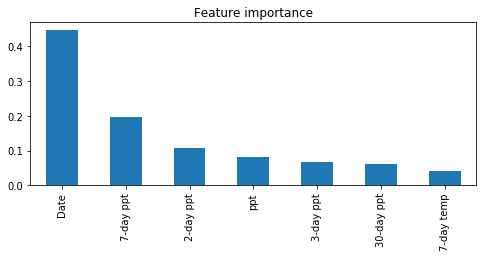

In [66]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# drop rows with NAN values because random forest cant process it
df_merged = df_merged.dropna()

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_merged['Date'] = pd.to_numeric(pd.to_datetime(df_merged['Date']))

# implement random forest
from sklearn.model_selection import train_test_split

# change the input parameters (i.e., predictors) here 
predictors = ['Date', 'ppt', '2-day ppt', '3-day ppt', '7-day ppt', '30-day ppt', '7-day temp']
X = df_merged[predictors]

# change the output parameters (i.e., sub8 flow, sub11 flow, sub12 flow) here 
y = df_merged['Flow8']

X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.25, random_state = 0)

rf_base = ske.RandomForestRegressor(n_estimators = 500, random_state = 0)

rf_base.fit(X_train, Y_train)

Y_pred = rf_base.predict(X_test)

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

fet_ind = np.argsort(rf_base.feature_importances_)[::-1]
fet_imp = rf_base.feature_importances_[np.argsort(rf_base.feature_importances_)][::-1]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
labels = np.asarray(X_train.columns[fet_ind])
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Feature importance')

### Using random grid model to improve base model

In [7]:
from sklearn.model_selection import RandomizedSearchCV
# the values below are somewhat selected arbitarily to cover a wide range of parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [8]:
# Use the random grid to search for best hyperparameters
rf = ske.RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.3s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   1.1s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   1.1s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1200, min

[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False, total=   2.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   1.9s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   1.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   1.8s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimator

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.2s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.2s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.2s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.8s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=800, min_

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total=   0.9s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total=   0.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   1.8s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   1.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=2000, min

[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False, total=   1.2s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.9s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.9s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.8s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV] 

[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   0.5s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   0.6s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   0.5s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.4s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_sampl

[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   1.6s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   1.5s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   1.3s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   1.2s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_e

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, total=   0.3s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   1.3s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   1.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   1.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=16

[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   1.5s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   1.4s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   1.4s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=   0.9s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimator

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [9]:
Y_pred = rf_random.predict(X_test)

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

training period explained variance: 0.6884152019381249
training period mean abs error: 0.02095827977922668
training period mean squared error: 0.0025464079269572836
training period r2: 0.6860642374725691


In [10]:
def evaluate(model, X_train, Y_train):
    predictions = model.predict(X_train)
    errors = abs(predictions - Y_train)
    mape = 100 * np.mean(errors / Y_train)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} cms.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

class color:
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'

print(color.BOLD + color.BLUE + 'For Base Model' + color.END)
base_accuracy = evaluate(rf_base, X_train, Y_train)

print(color.BOLD + color.BLUE + 'For Random Model' + color.END)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, Y_train)

print(color.BOLD + color.BLUE + 'Base vs random model comparison' + color.END)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

pprint(rf_random.best_params_)

For Base Model
Model Performance
Average Error: 0.0061 cms.
Accuracy = -inf%.
For Random Model
Model Performance
Average Error: 0.0062 cms.
Accuracy = -inf%.
Base vs random model comparison
Improvement of nan%.
{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}


C:\Users\jiyeow\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
from sklearn.model_selection import GridSearchCV

# if the random model performed better than the base model, then use the best random grid to create range of each hyperparameter

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [False]

# Create the better grid
better_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# We used randamized search to identify the better grid (i.e., narrow down the range for each hyperparameter)
# Now we use the better grid to instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = better_grid, 
                          cv = 3, n_jobs = 1, verbose = 2)


In [12]:
# Fit the grid search to the data
#grid_search.fit(X_train, Y_train)
#grid_search.best_params_

#best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X_train, Y_train)

#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [13]:
Y_pred = rf_random.predict(X_test)

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

training period explained variance: 0.6884152019381249
training period mean abs error: 0.02095827977922668
training period mean squared error: 0.0025464079269572836
training period r2: 0.6860642374725691


## Predict 2018 data, then compare against actual sample avg flow data

prediction period explained variance: -0.025095713797228525
prediction period mean abs error: 0.035719829325483815
prediction period mean squared error: 0.004295073060688906
prediction period r2: -0.3261497413529837


Text(0, 0.5, 'Predicted flow (cms)')

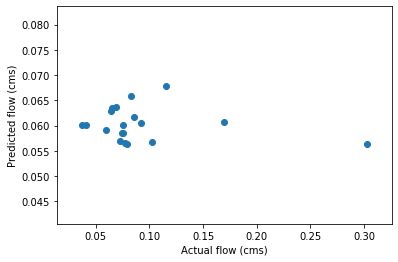

In [69]:
df_test = df_weather[df_weather["Year"].isin([2018])]
df_test = df_test.reset_index(drop=True)
#df_test = pd.merge(df_weather, df_testraw, left_on='Date', right_on='Sample date', how='inner')

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_test['Date'] = pd.to_numeric(pd.to_datetime(df_test['Date']))
df_test = df_test[predictors]

# use base or random depending on model performance
Y_pred = rf_base.predict(df_test)
#Y_pred = rf_random.predict(df_test)

df_predict = pd.DataFrame(Y_pred, columns=['flow_pred'])
df_predict = pd.merge(df_test, df_predict, left_index=True, right_index=True)

# this is flow-weighted sample avg flow
df_actual = pd.read_excel('Test data 2018.xlsx', sheet_name = 'By subwatershed')
df_actual = df_actual[(df_actual['Site'] == 'Sub8') & (df_actual['Sample type'] == 'Base')]
df_actual = df_actual[['Sample date','Flow (cms)']]
df_actual = df_actual.dropna()

df_predict = pd.merge(df_actual, df_predict['flow_pred'], left_index=True, right_index=True)
df_predict['error (%)'] = round(((df_predict['Flow (cms)']-df_predict['flow_pred'])/df_predict['Flow (cms)']*100), 0)

df_predict['Sample date'] = pd.to_datetime(df_predict['Sample date'])

print('prediction period explained variance:',explained_variance_score(df_predict['Flow (cms)'], df_predict['flow_pred']))
print('prediction period mean abs error:',mean_absolute_error(df_predict['Flow (cms)'], df_predict['flow_pred']))
print('prediction period mean squared error:',mean_squared_error(df_predict['Flow (cms)'], df_predict['flow_pred']))
print('prediction period r2:',r2_score(df_predict['Flow (cms)'], df_predict['flow_pred']))

plt.scatter(df_predict['Flow (cms)'], df_predict['flow_pred'])
plt.xlabel('Actual flow (cms)')
plt.ylabel('Predicted flow (cms)')

In [15]:
writer = pd.ExcelWriter('predict flow 2018.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()

## Predict 2018 daily data, compare with ISCO data

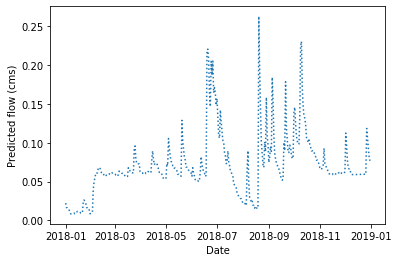

prediction period explained variance: 0.8583665448805242
prediction period mean abs error: 0.008264150025601606
prediction period mean squared error: 0.00045959837034803097
prediction period r2: 0.857995252332912


C:\Users\jiyeow\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
df_weathersub = df_weather[df_weather["Year"].isin([2018])]
df_test = df_weathersub
df_test = df_test[predictors]
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_test['Date'] = pd.to_numeric(pd.to_datetime(df_test['Date']))

# use base or random depending on model performance
#Y_pred = rf_base.predict(df_test)
Y_pred = rf_base.predict(df_test)


df_predict = pd.DataFrame(Y_pred, columns=['flow_pred'])
df_weathersub = df_weathersub[predictors]
df_predict = pd.merge(df_test, df_predict, left_index=True, right_index=True)

df_predict['Date'] = pd.to_datetime(df_predict['Date'])

plt.plot(df_predict['Date'], df_predict['flow_pred'], linestyle = 'dotted')
plt.xlabel('Date')
plt.ylabel('Predicted flow (cms)')
plt.show()

# this is ISCO daily avg flow
df_actual = df_flow[['Date', 'Flow8']]
df_actual['Year'] = pd.DatetimeIndex(df_actual['Date']).year
df_actual = df_actual[df_actual["Year"].isin([2018])]
df_actual = df_actual.dropna()

df_predict = pd.merge(df_predict, df_actual, left_on='Date', right_on='Date', how='right')
df_predict['error (%)'] = round(((df_predict['Flow8']-df_predict['flow_pred'])/df_predict['Flow8']*100), 0)

print('prediction period explained variance:',explained_variance_score(df_predict['Flow8'], df_predict['flow_pred']))
print('prediction period mean abs error:',mean_absolute_error(df_predict['Flow8'], df_predict['flow_pred']))
print('prediction period mean squared error:',mean_squared_error(df_predict['Flow8'], df_predict['flow_pred']))
print('prediction period r2:',r2_score(df_predict['Flow8'], df_predict['flow_pred']))

In [17]:
writer = pd.ExcelWriter('predict flow 2018 daily.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()

Average error: -5.35
Median error: -1.0


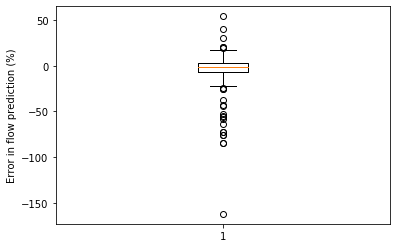

In [68]:
print('Average error:', round(df_predict['error (%)'].mean(),2))
print('Median error:', round(df_predict['error (%)'].median(),2))

plt.boxplot(df_predict['error (%)'])
plt.ylabel('Error in flow prediction (%)')
plt.show()